In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample

from itertools import chain
from random import sample 
import scipy

import sklearn.model_selection

## 1. Read the Data
First read in the dataframe.

In [2]:
d = pd.read_csv('findings_data_5000.csv')
d.head()

,Unnamed: 0,Finding Labels,Patient ID,Patient Age,Patient Gender,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,1,Cardiomegaly|Emphysema,1,57,M,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,No Finding,2,77,M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,Atelectasis,3,79,M,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Cardiomegaly|Edema|Effusion,4,55,F,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Consolidation|Mass,5,68,M,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## 2. Understand the Distribution
We want to see how different diseases are distributed with our disease of interest, as well as how age and gender are distributed:

In [3]:
all_labels = np.unique(list(chain(*d['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

[Text(0, 0.5, 'Number of Images with Label')]

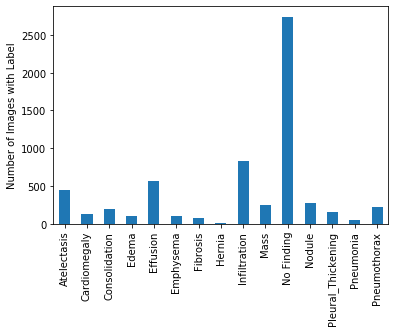

In [4]:
ax = d[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

**Since there are many combinations of potential findings, let's look at the 30 most common co-occurrences:**

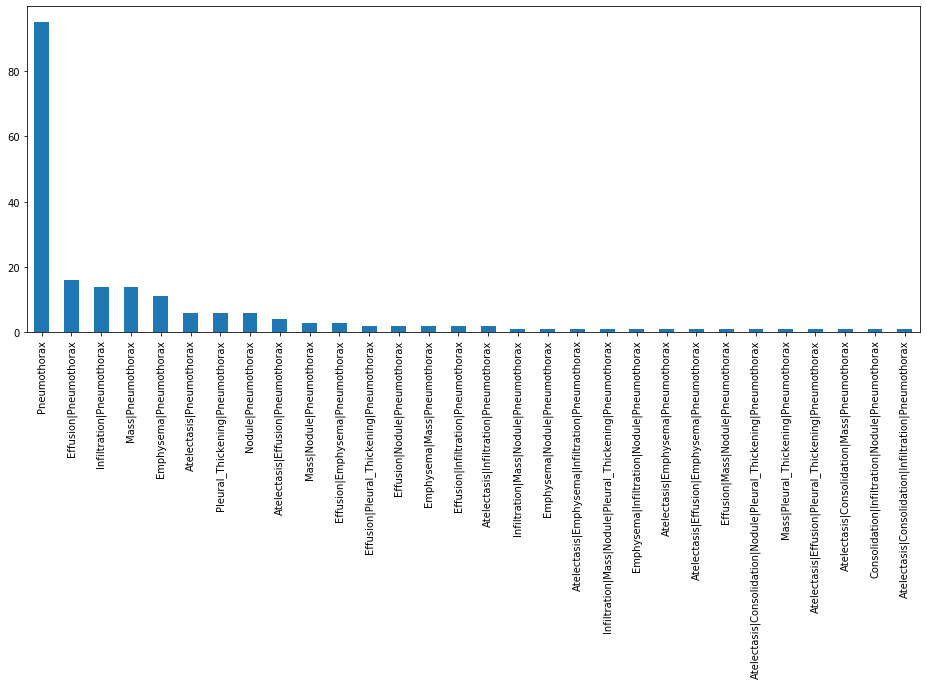

In [5]:
plt.figure(figsize=(16,6))
d[d.Pneumothorax==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

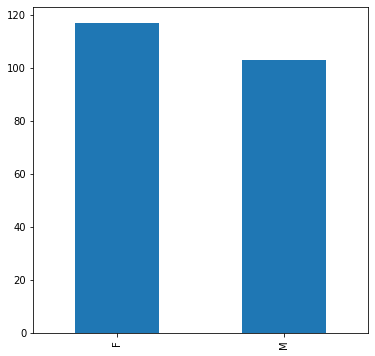

In [6]:
plt.figure(figsize=(6,6))
d[d.Pneumothorax ==1]['Patient Gender'].value_counts().plot(kind='bar')

(array([12., 18., 13., 21., 20., 47., 50., 26.,  9.,  4.]),
 array([ 7. , 14.6, 22.2, 29.8, 37.4, 45. , 52.6, 60.2, 67.8, 75.4, 83. ]),
 <a list of 10 Patch objects>)

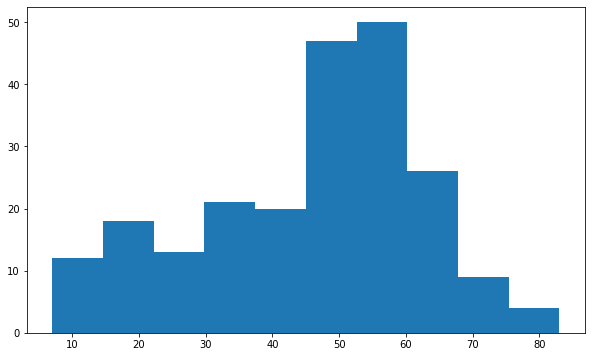

In [7]:
plt.figure(figsize=(10,6))
plt.hist(d[d.Pneumothorax==1]['Patient Age'])

## 3. Split the Data into Train/Test Partitions
Now, knowing what we know from above, let's create the appropriate training and validation sets for a model that we want to train to classify the presence of a Pneumothorax. Also, take care of the following conditions: 
1. To have _EQUAL_ amount of positive and negative cases of Pneumothorax in Training
2. To have 20% positive cases of Pneumothorax in the Test Set

**Hint: you can random sample the negative cases to obtain a balanced training set.**

In [8]:
train_df, valid_df = sklearn.model_selection.train_test_split(d, 
                                   test_size = 0.2, 
                                   stratify = d['Pneumothorax'])

In [9]:
train_df['Pneumothorax'].sum()/len(train_df)

0.04401100275068767

In [10]:
valid_df['Pneumothorax'].sum()/len(valid_df)

0.044

Great, our train_test_split made sure that we had the same proportions of Pneumothorax in both sets!

### Condition 1 - To have _EQUAL_ amount of positive and negative cases of Pneumothorax in Training 
But.... we know that we want our model to be trained on a set that has _equal_ proportions of pneumothorax and no pneumothorax, so we're going to have to throw away some data:

In [11]:
p_inds = train_df[train_df.Pneumothorax==1].index.tolist()
np_inds = train_df[train_df.Pneumothorax==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]

In [12]:
train_df['Pneumothorax'].sum()/len(train_df)

0.5

Ta-da! We randomly chose a set of non-Pneumothorax images using the sample() function that was the same length as the number of true Pneumothorax cases we had, and then we threw out the rest of the non-Pneumothorax cases. Now our training dataset is balanced 50-50.

### Condition 2 - To have 20% positive cases of Pneumothorax in the Test Set
Finally, we want to make the balance in our validation set more like 20-80 since our exercise told us that the prevalence of Pneumothorax in this clinical situation is about 20%:

In [14]:
p_inds = valid_df[valid_df.Pneumothorax==1].index.tolist()
np_inds = valid_df[valid_df.Pneumothorax==0].index.tolist()

# The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
np_sample = sample(np_inds,4*len(p_inds))
valid_df = valid_df.loc[p_inds + np_sample]

In [15]:
valid_df['Pneumothorax'].sum()/len(valid_df)

0.2